In [267]:
from control import matlab as MATLAB
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


# AERO-2 MIMO system
# Moment of inertia about pitch-axis (kg-m^2)
Jp = 0.0232  # from CAD: 23188500.45 g-mm^2

# Moment of inertia about pitch-axis (kg-m^2)
Jy = 0.0238  # from CAD: 23810415.95 g-mm^2;
Dt = 0.16743  # distance from pivot to center of rotor/propeller (m)

# Experiment Pitch Parameters
Ksp = 0.00744  # Stiffness (N-m/(rad))
Dp = 0.00199  # Damping (N-m/(rad/s))
Kpp = 0.00321  # Pitch thrust gain (N/V)
Kpy = 0.00137  # Pitch from yaw thrust gain (N/V)

# Experimental Yaw Parameters
Dy = 0.00192  # Damping (N-m/(rad/s))
Kyy = 0.00610  # Yaw thrust gain Thrust (N/V)
Kyp = -0.00319  #  Yaw from pitch thrust gain (N/V)

# Set up state-space system
A = [[0, 1, 0, 0],
     [-Ksp/Jp, -Dp/Jp, 0, 0],
     [0, 0, 0, 1],
     [0, 0, 0, -Dy/Jy]]

A2 = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [-Ksp/Jp, 0, -Dp/Jp, 0],
     [0, 0, 0, -Dy/Jy]]

B = [[0, 0],
     [Kpp*Dt/Jp, Kpy*Dt/Jp],
     [0, 0],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]

B2 = [[0, 0],
     [0, 0],
     [Kpp*Dt/Jp, Kpy*Dt/Jp],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]  

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

D = [[0, 0],
     [0, 0]]


K2 = np.array([[98.2088,-140.0645,80.7,-24.3],[47.6,78.0,40.6,52.9]])
K = np.array([[98.2088,80.7,-140.0645,-24.3],[47.6,40.6,78.0,52.9]])


# AERO = MATLAB.ss(A - np.matmul(B, K), B, C, D)
AERO = MATLAB.ss(A, B, C, D)
print(LA.eig(A-np.matmul(B,K))[0])
print(LA.eig(A2-np.matmul(B2,K2))[0])


print(AERO)



[-1.15700606+1.26383033j -1.15700606-1.26383033j -1.46937415+2.11752952j
 -1.46937415-2.11752952j]
[-1.15700606+1.26383033j -1.15700606-1.26383033j -1.46937415+2.11752952j
 -1.46937415-2.11752952j]
<LinearIOSystem>: sys[58]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.          1.          0.          0.        ]
     [-0.32068966 -0.08577586  0.          0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.          0.          0.         -0.08067227]]

B = [[ 0.          0.        ]
     [ 0.02316596  0.00988703]
     [ 0.          0.        ]
     [-0.02244125  0.04291273]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]



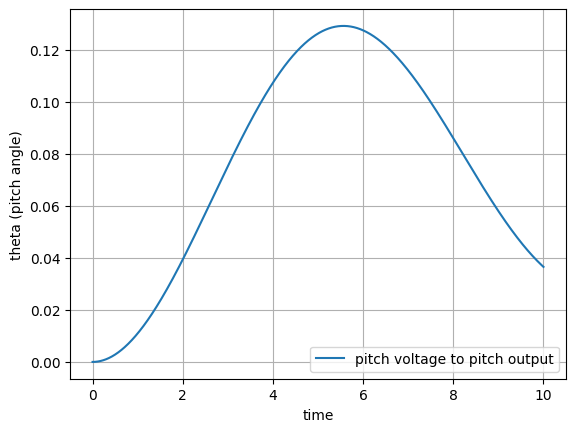

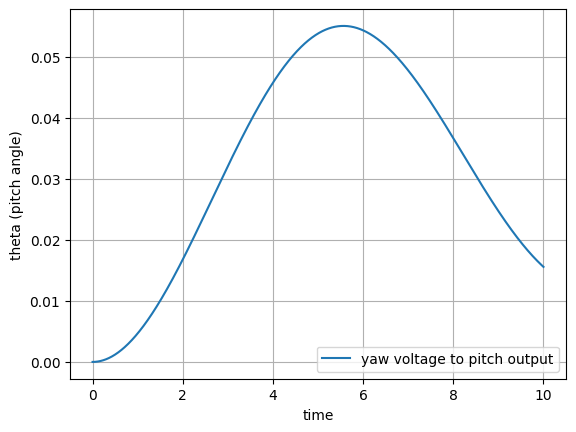

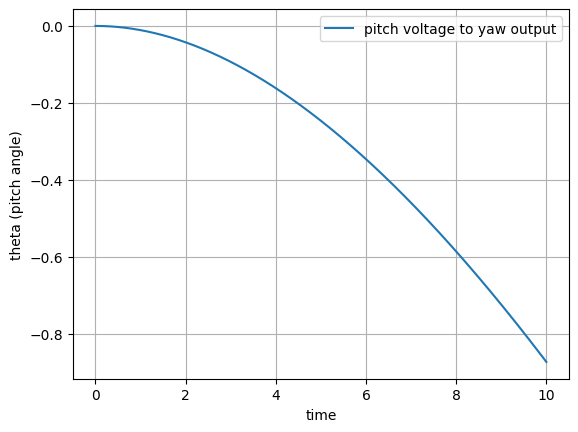

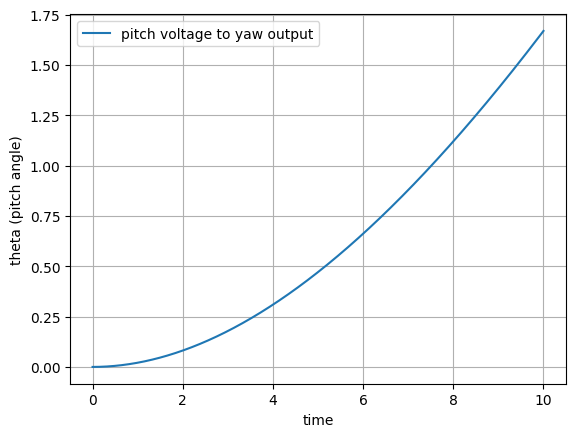

In [268]:
time = np.linspace(0, 10, 1000)

# use lsim to define my own inputs
y_in1_out1, T = MATLAB.step(AERO, time, input=0, output=0)

plt.figure()
plt.plot(T, y_in1_out1, label='pitch voltage to pitch output')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('theta (pitch angle)')
plt.grid()

y_in2_out1, T = MATLAB.step(AERO, time, input=1, output=0)

plt.figure()
plt.plot(T, y_in2_out1, label='yaw voltage to pitch output')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('theta (pitch angle)')
plt.grid()

y_in1_out2, T = MATLAB.step(AERO, time, input=0, output=1)

plt.figure()
plt.plot(T, y_in1_out2, label='pitch voltage to yaw output')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('theta (pitch angle)')
plt.grid()

y_in2_out2, T = MATLAB.step(AERO, time, input=1, output=1)

plt.figure()
plt.plot(T, y_in2_out2, label='pitch voltage to yaw output')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('theta (pitch angle)')
plt.grid()

### Basic Example using LSIM

Text(0, 0.5, 'Yaw Angle (Radians)')

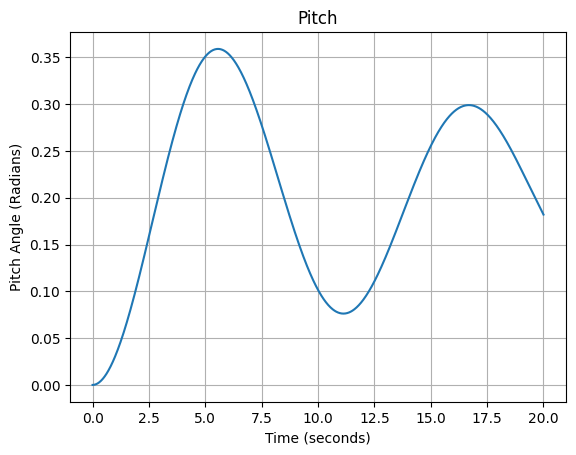

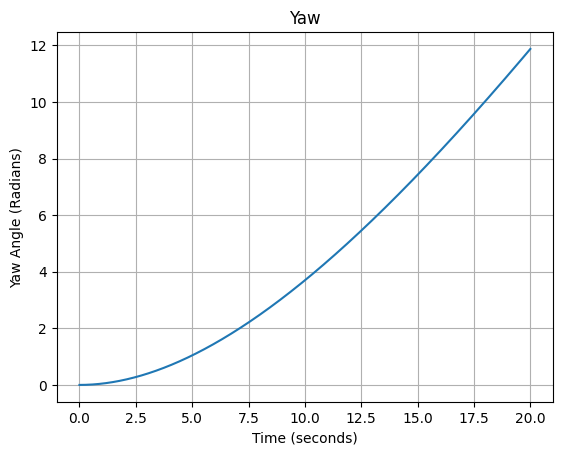

In [269]:
shape = (1000,)
time = np.linspace(0, 20, shape[0])

v1 = np.zeros(shape)
v1 = np.full(shape,1.5)
v2 = np.full(shape,3)
# v2 = np.zeros(shape)
inputs = [v1,v2]

U = np.array(inputs)
U = np.transpose(U)

yout, T, xout = MATLAB.lsim(AERO, U, time, 0)

plt.plot(T,yout[:,0])
plt.title('Pitch')
plt.grid()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Angle (Radians)')


plt.figure()
plt.plot(T,yout[:,1])
plt.title('Yaw')
plt.grid()
plt.xlabel('Time (seconds)')
plt.ylabel('Yaw Angle (Radians)')





### Trying to identify existing data labels using LSIM

- Would changing the control system gains change the dynamic model of the system?
- Should I be able to simulated the motion of the 2DOF using voltages I measured?
- If I can't simulate 2DOF motion then I can't do parameter estimation because the model I'm using is wrong.
- When validating simulations with real results, how sensitive is the system to balance and initial velocity?

In [270]:
def lowpass(order, highStop, sampleRate, data):
    '''
    The function uses a Butterworth low pass filter and returns the filtered time-series data

    :param order: order of the filter (higher order means faster roll off), int
    :param highStop: high frequency before the roll off starts, int
    :param sampleRate: sample rate at which the data was collected, int
    :param data: collected data, array_like
    '''
    b, a = butter(order, highStop, 'lowpass', fs=sampleRate)
    return filtfilt(b, a, data)



[ 0.1069      0.0137472   0.3145     -0.01395992]


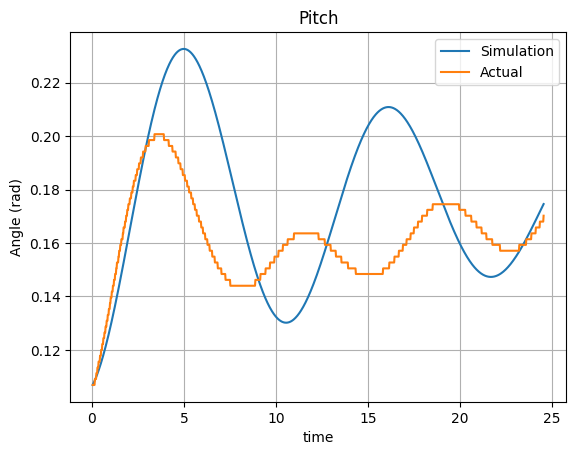

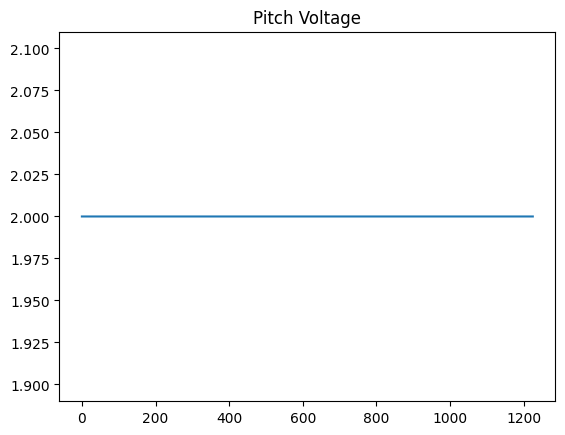

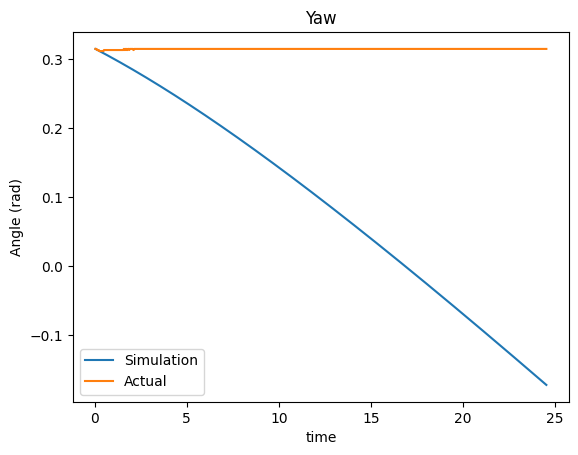

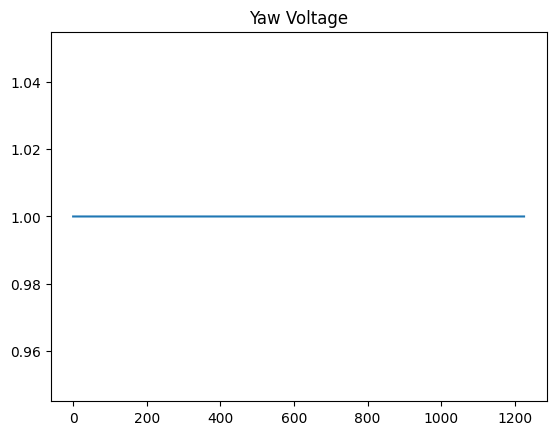

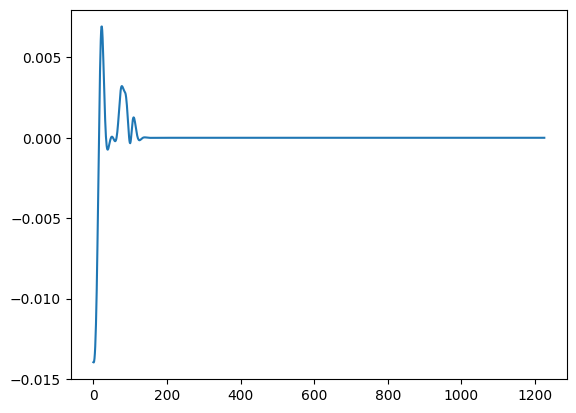

In [271]:
import os
import pandas as pd
from scipy.signal import butter, filtfilt


# os.chdir('/home/coder/workspace/Data/2DOF_Machine/')
# name = '2DOF_Balanced_Data2_23-10-06_with_CG.csv'

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID/')
name = 'aero2_no_control.csv'
data = pd.read_csv(name)

# end = 300
end = len(data)
t = data.iloc[1:,0].values[0:end]
t = np.linspace(t[0],t[-1],len(t))
time = np.linspace(0, t[-1], len(t))[0:end]
Vp = data.iloc[1:,1].values[0:end]
Vy = data.iloc[1:,2].values[0:end]
pitch = data.iloc[1:,3].values[0:end]
yaw = data.iloc[1:,4].values[0:end]
sampleRate = len(t)/t[-1]

order = 3
highStop = 2

pitch_filt = lowpass(order, highStop, sampleRate, pitch)
yaw_filt = lowpass(order, highStop, sampleRate, yaw)

tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch_filt, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity = np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw_filt, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

# yaw_velocity_IC = richardson_extrapolation_forward_difference(pitch_velocity[0:3], t[0:3], h, num_iterations=3)
ICs = np.array([pitch[1], pitch_velocity[0], yaw[1], yaw_velocity[0]])


# print(Vy[0:10])
print(ICs)


U = np.array([Vp,Vy])
U = np.transpose(U)

yout, T, xout = MATLAB.lsim(AERO, U, t, ICs)

plt.figure()
plt.title('Pitch')
plt.plot(T,yout[:,0])
plt.plot(T,pitch)
plt.legend(['Simulation', 'Actual'])
plt.xlabel('time')
plt.ylabel('Angle (rad)')
plt.grid()

plt.figure()
plt.plot(Vp)
plt.title('Pitch Voltage')

plt.figure()
plt.title('Yaw')
plt.plot(T,yout[:,1])
plt.plot(T,yaw)
plt.legend(['Simulation', 'Actual'])
plt.xlabel('time')
plt.ylabel('Angle (rad)')

plt.figure()
plt.plot(Vy)
plt.title('Yaw Voltage')

plt.figure()
plt.plot(yaw_velocity)



### Generating synthetic data using LSIM

(0.0, 100.0)

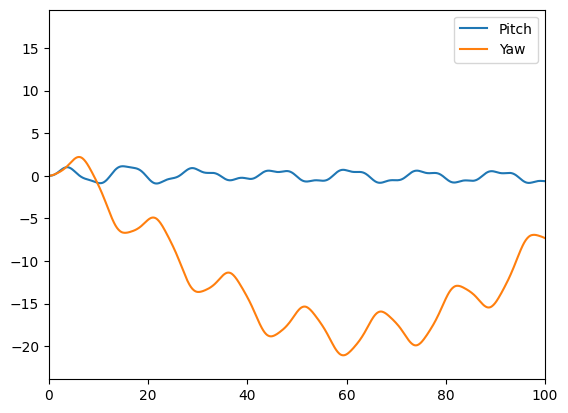

In [272]:
shape = (100000,)
time = np.linspace(0, 10000, shape[0])

amp = 10 # Volts
fn = 0.2 # Hz
noise_stddev = 0.25 # Standard Deviation of the Gaussian Noise

# Generate sine wave
Vp = amp * np.sin(2 * np.pi * fn * time) + 2 * np.cos(2 * np.pi * 0.005 * time) + 0.4 * np.cos(2 * np.pi * 1 * time)

# plt.plot(Vp)

# Add random Gaussian noise
noise = np.random.normal(loc=0, scale=noise_stddev, size=len(time))
Vp = Vp + noise


Vy = amp * np.cos(2 * np.pi * fn/3 * time) - np.sin(5*time)
Vy = Vy + noise

U = np.array([Vp,Vy])
U = np.transpose(U)

yout, T, xout = MATLAB.lsim(AERO, U, time, 0)

plt.plot(T,yout)
plt.legend(['Pitch','Yaw'],loc='best')
plt.xlim([0,100])

In [273]:
def calculate_snr(signal, noise):
    """Calculate signal-to-noise ratio (SNR) in dB."""
    signal_power = np.mean(signal**2)  # Signal power
    noise_power = np.mean(noise**2)     # Noise power
    snr_db = 10 * np.log10(signal_power / noise_power)  # SNR in dB
    return snr_db

SNR for Pitch: 35.5664217834427 dB
SNR for Yaw: 78.91294133481371 dB
[-0.0020643  -0.00371223  0.00225029 ... -0.23924129 -0.2448436
 -0.23123244]


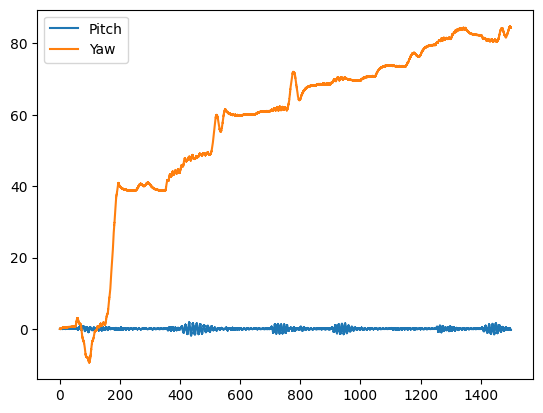

In [274]:
shape = (5000,)
time = np.linspace(0, 50, shape[0])

num = 30

Vp = np.array([])
for i in range(num):
    amp1 = 6*np.random.rand()
    amp2 = 6*np.random.rand()
    amp3 = 6*np.random.rand()
    amp4 = 6*np.random.rand()

    freq1 = 1.0*np.random.rand()
    freq2 = 1.0*np.random.rand()
    freq3 = 1.0*np.random.rand()
    freq4 = 1.0*np.random.rand()

    vp = amp1*np.sin(2*np.pi*freq1*time)+amp2*np.sin(2*np.pi*freq2*time)+amp3*np.sin(2*np.pi*freq3*time)-amp4*np.sin(2*np.pi*freq4*time)
    Vp = np.append(Vp, vp)

Vy = np.array([])
for i in range(num):
    amp1 = 6*np.random.rand()
    amp2 = 6*np.random.rand()
    amp3 = 6*np.random.rand()

    freq1 = 1.0*np.random.rand()
    freq2 = 1.0*np.random.rand()
    freq3 = 1.0*np.random.rand()

    vy = amp1*np.sin(2*np.pi*freq1*time)+amp2*np.sin(2*np.pi*freq2*time)+amp3*np.sin(2*np.pi*freq3*time)
    Vy = np.append(Vy, vy)

time = np.linspace(0,50*num, len(Vp))


U = np.array([Vp,Vy])
U = np.transpose(U)

yout, T, xout = MATLAB.lsim(AERO, U, time, 0)

# Noise
# Shoot for SNR (signal to noise ratio) 10 dB
noise = np.random.normal(loc=0, scale=0.007, size=len(time))
noise = np.vstack((noise,noise))
noise = np.transpose(noise)
yout = yout + noise

# Calculate SNR for both signals
snr_pitch = calculate_snr(yout[:,0], noise[:,0])
snr_yaw = calculate_snr(yout[:,1], noise[:,1])

print("SNR for Pitch:", snr_pitch, "dB")
print("SNR for Yaw:", snr_yaw, "dB")

plt.plot(T,yout)
plt.legend(['Pitch','Yaw'],loc='best')
# plt.xlim([0,100])
print(yout[:,0])

### Writing Data

In [275]:
import csv

pitch = yout[:,0]
yaw = yout[:,1]

combined_array = np.column_stack((time, Vp, Vy, pitch, yaw))


labels = ['time(s)', 'Vp(V)', 'Vy(V)', 'pitch(rad)', 'yaw(rad)']
combined_array_labeled = np.vstack((labels, combined_array))

os.chdir('/home/coder/workspace/VanderWiel/Fennec2023/SystemID')
with open('simulated_outputs_uncontrolled.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(combined_array_labeled)

### Testing results

In [82]:
# -0.2842088 -0.321
# -0.14776465 -0.086
# 0.02243017 0.023
# 0.008703627 0.0099
# [-0.31763202, -0.096758954, 0.022022616, 0.008049794]


# Set up state-space system
A = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [-Ksp/Jp, 0, -Dp/Jp, 0],
     [0, 0, 0, -Dy/Jy]]

# A_est = [[0, 0, 1, 0],
#      [0, 0, 0, 1],
#      [-0.2842088, 0, -0.14776465, 0],
#      [0, 0, 0, -Dy/Jy]]

A_est = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [-0.31763202, 0, -0.096758954, 0],
     [0, 0, 0, -Dy/Jy]]

B = [[0, 0],
     [0, 0],
     [Kpp*Dt/Jp, Kpy*Dt/Jp],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]

# B_est = [[0, 0],
#      [0, 0],
#      [0.02243017, 0.008703627],
#      [Kyp*Dt/Jy, Kyy*Dt/Jy]]

B_est = [[0, 0],
     [0, 0],
     [0.022022616, 0.008049794],
     [Kyp*Dt/Jy, Kyy*Dt/Jy]]

C = [[1, 0, 0, 0],
     [0, 0, 1, 0]]

D = [[0, 0],
     [0, 0]]

AERO1 = MATLAB.ss(A, B, C, D)
AERO2 = MATLAB.ss(A_est,B_est,C,D)

print(AERO1)
# print(AERO2)

<LinearIOSystem>: sys[38]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.          0.          1.          0.        ]
     [ 0.          0.          0.          1.        ]
     [-0.32068966  0.         -0.08577586  0.        ]
     [ 0.          0.          0.         -0.08067227]]

B = [[ 0.          0.        ]
     [ 0.          0.        ]
     [ 0.02316596  0.00988703]
     [-0.02244125  0.04291273]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0. 0.]
     [0. 0.]]



In [83]:
def nrmse(actual_values, predicted_values):
        """
        Calculate Normalized Root Mean Squared Error (NRMSE) for regression. Normalized over the range of the target variable
        In this case it's the range of the pitch acceleration data

        Parameters:
        - actual_values: NumPy array or list of actual values.
        - predicted_values: NumPy array or list of predicted values.

        Returns:
        - nrmse: Normalized Root Mean Squared Error.
        """
        actual_values = np.array(actual_values).flatten()
        predicted_values = np.array(predicted_values).flatten()

        if len(actual_values) != len(predicted_values):
            raise ValueError("Length of actual_values and predicted_values must be the same.")

        # Calculate RMSE
        rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

        # Calculate the range of the target variable
        target_range = np.max(actual_values) - np.min(actual_values)

        # Calculate NRMSE
        nrmse = (rmse / target_range) * 100 # Expressed as a percentage

        return nrmse

Pitch NRMSE: 2.028863280758439 %
Yaw NRMSE: 2.0649349621534028 %


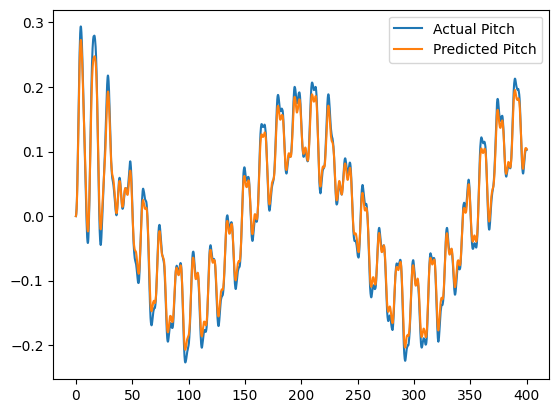

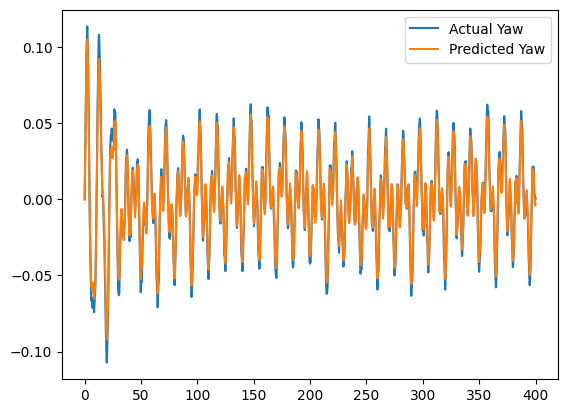

In [84]:
shape = (4000,)
time = np.linspace(0, 400, shape[0])

amp = 1 # Volts
fn = 0.2 # Hz
noise_stddev = 0.25 # Standard Deviation of the Gaussian Noise

# Generate sine wave
Vp = amp * np.sin(2 * np.pi * fn * time) + 2 * np.cos(2 * np.pi * 0.005 * time) + 0.4 * np.cos(2 * np.pi * 1 * time)

# plt.plot(Vp)

# Add random Gaussian noise
noise = np.random.normal(loc=0, scale=noise_stddev, size=len(time))
Vp = Vp + noise


Vy = amp * np.cos(2 * np.pi * fn/3 * time) - np.sin(5*time)
Vy = Vy + noise

U = np.array([Vp,Vy])
U = np.transpose(U)

yout1, T1, xout1 = MATLAB.lsim(AERO1, U, time, 0)
yout2, T2, xout2 = MATLAB.lsim(AERO2, U, time, 0)


plt.plot(T1,yout1[:,0])
plt.plot(T2,yout2[:,0])
plt.legend(['Actual Pitch','Predicted Pitch'],loc='best')
# plt.xlim([0,100])

plt.figure()
plt.plot(T1,yout1[:,1])
plt.plot(T2,yout2[:,1])
plt.legend(['Actual Yaw','Predicted Yaw'],loc='best')

print('Pitch NRMSE:', nrmse(yout1[:,0],yout2[:,0]), '%')
print('Yaw NRMSE:', nrmse(yout1[:,1],yout2[:,1]), '%')
